### Fractional Differencing

### Background
Fractional Differencing is a signal processing technique that is used to remove the non-stationarity from the time series while maintaining as much memory as possible. It is widely used in FSI to prepare training data for machine learning algorithms. In this [open-source project](https://github.com/ritchieng/fractional_differencing_gpu/blob/master/notebooks/gpu_fractional_differencing.ipynb) done by Ensemble Capital, fractional differencing computation is accelerated via `cudf.appy_chunk` method in the GPU. It achieves hundreds of times acceleration compared with CPU implementation in their [report](https://www.researchgate.net/publication/335159299_GFD_GPU_Fractional_Differencing_for_Rapid_Large-scale_Stationarizing_of_Time_Series_Data_while_Minimizing_Memory_Loss). 
Using `apply_rows` and `apply_chunks` method from the cudf library is the easiest way of customizing GPU computations as covered in this [blog](https://medium.com/rapids-ai/user-defined-functions-in-rapids-cudf-2d7c3fc2728d). However, it is not the most efficient way.

In this notebook, we are going to show how to use Numba to do fractional differencing computation efficiently. As gQuant wrap the fractional differencing function in the computation node, we are going to show it is easy for data scientists to compute fractional differencing signals and use them to generate alpha signals. 

### Environment Preparation

In [1]:
import sys
sys.path.append('..')

import warnings
import gquant
from gquant.cuindicator import get_weights_floored, fractional_diff
import nxpd
import ipywidgets as widgets
from nxpd import draw
import os
import time
import numpy as np
from numba import cuda
import cudf
import inspect
warnings.simplefilter("ignore")

Copy the fractional differencing code from the [open-source project](https://github.com/ritchieng/fractional_differencing_gpu/blob/master/notebooks/gpu_fractional_differencing.ipynb). We will use this as our benchmark reference

In [2]:
def moving_dot_product_kernel(in_data, out, window_size, weights):
    # Set the first window_size-1 rows in each chunk to np.nan due 
    # insufficient history
    for i in range(cuda.threadIdx.x, window_size - 1, cuda.blockDim.x):
        out[i] = np.nan
    
    # Compute dot product of preceding window_size rows
    for i in range(cuda.threadIdx.x + window_size - 1, in_data.size, cuda.blockDim.x):
        rolling_dot_product = 0.0
        
        k = 0
        for j in range(i - window_size + 1, i + 1):
            rolling_dot_product += in_data[j] * weights[k][0]
            k += 1
        
        out[i] = rolling_dot_product 
        
def frac_diff_gpu(df, d, floor=1e-3):
    r"""Fractionally difference time series via GPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    
    # Bring dataframe to GPU, reset index for GPU dot product kernel
    # gdf_raw = cudf.from_pandas(df).reset_index(drop=True)
    gdf_raw = df
    gdf_raw.columns = ['in_data']

    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(gdf_raw), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights and as contiguous
    weights = np.ascontiguousarray(weights[::-1])
    
    # Bring weights to GPU
    gdf_weights = cudf.DataFrame()
    gdf_weights[gdf_raw.columns[0]] = weights.reshape(-1)

    # Length of data
    data_length = len(gdf_raw)

    # T4: max of 518 threads per block.
    # V100: max 1024 threads per block
    threads_per_block = 518

    # Chunk size split
    # This has to be improved, but as a v0.1, it's sufficient to show speed-up
    # Up to easily 100 million data points
    trunk_size = data_length

    # Get fractionally differenced time series through GPU function
    gdf_raw_fd = gdf_raw.apply_chunks(moving_dot_product_kernel,
                                 incols=['in_data'],
                                 outcols=dict(out=np.float64),
                                 kwargs=dict(window_size=weights_window_size, weights=weights),
                                 chunks=list(range(0, data_length, trunk_size)) + [data_length],
                                 tpb=threads_per_block)
    
    # Bring to CPU for normal manipulation
    # df_raw_fd = gdf_raw_fd.to_pandas().dropna().iloc[:-1, 1]
    
    return gdf_raw_fd, weights

Following is the gQuant's fractional differencing implementation via Numba library

In [3]:
print(inspect.getsource(fractional_diff))

def fractional_diff(input_arr, d=0.5, floor=1e-3, min_periods=None,
                    thread_tile=2, number_of_threads=512):
    """
    The fractional difference computation method.

    Arguments:
    -------
      input_arr: numba.cuda.DeviceNDArray or cudf.Series
        the input array to compute the fractional difference
      d: float
        the differencing value. range from 0 to 1
      floor: float
        minimum value for the weights for computational efficiency.
      min_periods: int
        default the lengths of the weights. Need at least min_periods of
        non-na elements to get fractional difference value
      thread_tile: int
        each thread will be responsible for `thread_tile` number of
        elements in window computation
      number_of_threads: int
        number of threads in a block for CUDA computation

    Returns
    -------
    (numba.cuda.DeviceNDArray, np.array)
        the computed fractional difference array and the weight array tuple

  

It launches the Numba kernel, which defined as:

In [4]:
@cuda.jit(device=True)
def conv_window(shared, history_len, out_arr, window_size,
                arr_len, offset, offset2, min_size):
    """
    This function is to do convolution for one thread

    Arguments:
    ------
     shared: numba.cuda.DeviceNDArray
        3 chunks of data are stored in the shared memory
        the first [0, window_size) elements is the chunk of data that is
        necessary to compute the first convolution element.
        then [window_size, window_size + thread_tile * blockDim) elements
        are the inputs allocated for this block of threads
        the last [window_size + thread_tile,
        window_size + thread_tile + window_size) is to store the kernel values
     history_len: int
        total number of historical elements available for this chunk of data
     out_arr: numba.cuda.DeviceNDArray
        output gpu_array of size of `thread_tile`
     window_size: int
        the number of elements in the kernel
     arr_len: int
        the chunk array length, same as `thread_tile`
     offset: int
        indicate the starting index of the chunk array in the shared for
        this thread.
     offset: int
        indicate the starting position of the weights/kernel array
     min_size: int
         the minimum number of non-na elements
    """
    for i in range(arr_len):
        if i + history_len < window_size-1:
            out_arr[i] = np.nan
        else:
            s = 0.0
            average_size = 0
            for j in range(0, window_size):
                if not (cmath.isnan(
                        shared[offset + i - j])):
                    s += (shared[offset + i - j] *
                          shared[offset2 + window_size - 1 - j])
                    average_size += 1
            if average_size >= min_size:
                out_arr[i] = s
            else:
                out_arr[i] = np.nan

                
@cuda.jit
def kernel(in_arr, weight_arr, out_arr, window,
           arr_len, thread_tile, min_size):
    """
    This kernel is to do 1D convlution on `in_arr` array with `weight_arr`
    as kernel. The results is saved on `out_arr`.

    Arguments:
    ------
     in_arr: numba.cuda.DeviceNDArray
        input gpu array
     weight_arr: numba.cuda.DeviceNDArray
        convolution kernel gpu array
     out_arr: numba.cuda.DeviceNDArray
        output gpu_array
     window: int
        the number of elements in the weight_arr
     arr_len: int
        the input/output array length
     thread_tile: int
        each thread is responsible for `thread_tile` number of elements
     min_size: int
         the minimum number of non-na elements
    """
    shared = cuda.shared.array(shape=0,
                               dtype=numba.float64)
    block_size = cuda.blockDim.x  # total number of threads
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    bid = cuda.blockIdx.x
    starting_id = bid * block_size * thread_tile

    # copy the thread_tile * number_of_thread_per_block into the shared
    for j in range(thread_tile):
        offset = tx + j * block_size
        if (starting_id + offset) < arr_len:
            shared[offset + window - 1] = in_arr[
                starting_id + offset]
        cuda.syncthreads()

    # copy the window - 1 into the shared
    for j in range(0, window - 1, block_size):
        if (((tx + j) <
             window - 1) and (
                 starting_id - window + 1 + tx + j >= 0)):
            shared[tx + j] = \
                in_arr[starting_id - window + 1 + tx + j]
        cuda.syncthreads()
    # copy the weights into the shared
    for j in range(0, window, block_size):
        element_id = tx + j
        if (((tx + j) < window) and (element_id < window)):
            shared[thread_tile * block_size + window - 1 + tx +
                   j] = weight_arr[tx + j]
        cuda.syncthreads()
    # slice the shared memory for each threads
    start_shared = tx * thread_tile
    his_len = min(window - 1,
                  starting_id + tx * thread_tile)
    # slice the global memory for each threads
    start = starting_id + tx * thread_tile
    end = min(starting_id + (tx + 1) * thread_tile, arr_len)
    sub_outarr = out_arr[start:end]
    sub_len = end - start
    conv_window(shared, his_len, sub_outarr,
                window, sub_len,
                window - 1 + start_shared,
                thread_tile * block_size + window - 1,
                min_size)

Fractional differencing is essentially doing 1D convolution computation with the kernel values set to be the weights computed from `get_weights_floored`. Check the original [notebook](https://github.com/ritchieng/fractional_differencing_gpu/blob/master/notebooks/gpu_fractional_differencing.ipynb) for the details of the meanings of the weights. To make convolution computation faster, we divide the long input array into small chunks and send to different thread blocks. All the array chunks and the weights are loaded into the GPU shared memory for fast IO. The device function `conv_window` is doing the convolution computation for one thread.

We can compare the performance of gQuant implementation vs the original one:

In [5]:
for i in range(5, 9):
    df_raw = cudf.DataFrame()
    ran_array = np.random.rand(10**int(i))
    df_raw['in'] = ran_array
    df_raw2 = cudf.DataFrame()
    df_raw2['in'] = ran_array

    # Start timer
    start = time.time()
    df_raw_fd_from_gpu, weights = frac_diff_gpu(df_raw, d=0.5, floor=5e-5)
    # End timer
    end = time.time()
    duration = end - start

    start = time.time()
    gquant_gpu, weights = fractional_diff(df_raw2['in'], d=0.5, floor=5e-5)
    cuda.synchronize()
    end = time.time()
    #(df_raw_fd_from_gpu.values)
    
    err = np.abs(df_raw_fd_from_gpu['out'].to_array() - np.array(gquant_gpu)[weights.size-1:]).max()
    print('array size %d, Ensemble: time %.3f s, gQuant Time %.3f s, speed up %.2f, error %.4f ' % (10**int(i), duration, end - start, duration / (end-start), err))


array size 100000, Ensemble: time 0.507 s, gQuant Time 0.408 s, speed up 1.24, error 0.0000 
array size 1000000, Ensemble: time 0.079 s, gQuant Time 0.004 s, speed up 22.30, error 0.0000 
array size 10000000, Ensemble: time 0.669 s, gQuant Time 0.008 s, speed up 87.18, error 0.0000 
array size 100000000, Ensemble: time 6.455 s, gQuant Time 0.052 s, speed up 124.65, error 0.0000 


For the array of length 100m, gQuant can achieve 100x speedup compare with the Ensemble Capitial's GPU implementatoin. 

### Use the fractional differencing signal to trade stocks

We will use the same [XGBoost example](https://github.com/rapidsai/gQuant/blob/master/notebooks/06_xgboost_trade.ipynbx) to do backtest with fractional differencing signals. The workflow includes the following steps:

1. Load the 5000 end-of-day stocks CSV data into the dataframe

2. Add rate of return feature to the dataframe.

3. Clean up the data by removing low volume stocks and extreme rate of returns stocks.

4. Compute the features based on different fractional differencing signals of the closing prices of the stocks 

5. Split the data in training and testing and build a XGBoost model based on the training data. From the XGBoost model, compute the trading signals for all the data points.

5. Run backtesting and compute the returns from this strategy for each of the days and stock symbols 

6. Run a simple portfolio optimization by averaging the stocks together for each of the trading days.

7. Compute the Sharpe ratio and cumulative return results for both training and testing datasets

The whole workflow can be organized into a computation graph, which are fully described in a yaml file. 

Each nodes has a unique id, a node type, configuration parameters and input nodes ids. gQuant takes this yaml file, wires it into a graph to visualize it. 

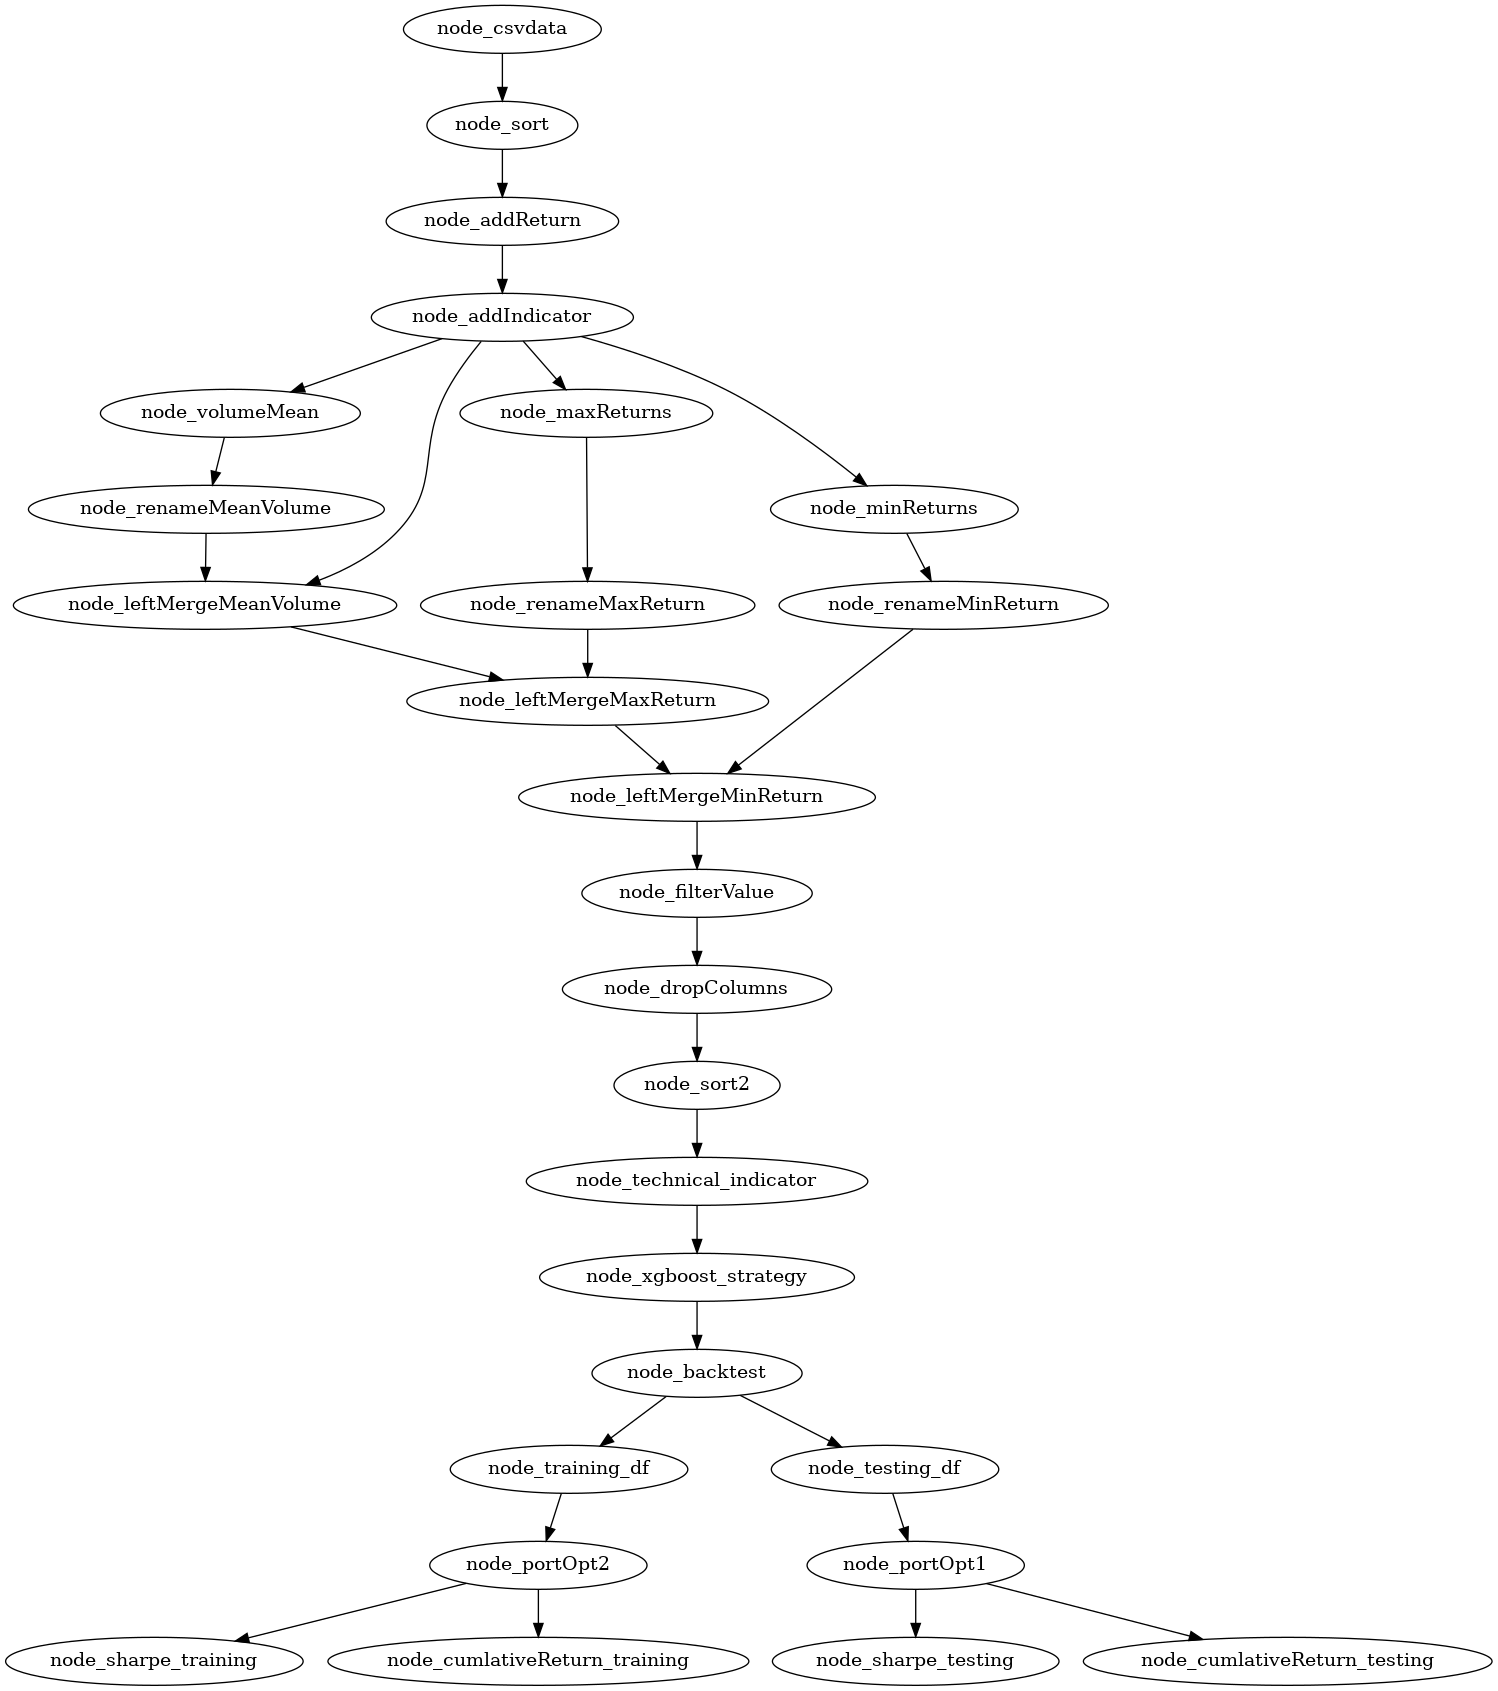

In [6]:
%reset -s -f
import sys
import os
sys.path.append('..')
import gquant
from gquant.dataframe_flow import TaskGraph
import ipywidgets as widgets
import nxpd
from nxpd import draw
import warnings
warnings.simplefilter("ignore")

task_graph = TaskGraph.load_taskgraph('../task_example/xgboost_trade.yaml')
draw(task_graph.viz_graph(), show='ipynb')

Define some constants for the data filters. If using GPU of 32G memory, you can safely set the min_volume to 5.0

In [7]:
min_volume = 400.0
min_rate = -10.0
max_rate = 10.0

The features used for XGBoost algorithm are prepared in the `node_technical_indicator` node, where `cuIndicator` module is used to compute the technical indicators in the GPU for all the stock symbols. `node_xgboost_strategy` is the node that is used to compute the trading signals from the stock technical indicators. Each of the gQuant node is implemented by overwriting "columns_setup" and "process" methods of the Node base class. Please refer to [customize nodes notebook](https://github.com/rapidsai/gQuant/blob/master/notebooks/05_customize_nodes.ipynb) for details. Define the function to visualize the backtest results 

In [8]:
# define the function to format the plots
def plot_figures(o):
    # format the figures
    figure_width = '1200px'
    figure_height = '400px'
    sharpe_number = o[0]
    cum_return_train = o[1]
    cum_return_train.layout.height = figure_height
    cum_return_train.layout.width = figure_width
    cum_return_train.title = 'Training P & L %.3f' % (sharpe_number)
    sharpe_number = o[2]
    cum_return_test = o[3]
    cum_return_test.layout.height = figure_height
    cum_return_test.layout.width = figure_width
    cum_return_test.title = 'Testing P & L %.3f' % (sharpe_number)

    return widgets.VBox([cum_return_train, cum_return_test])

In this example, we are going to add 5 fractional differencing signals from the closing prices 

In [9]:
indicator_conf = {
    "indicators": [
        {"function": "port_fractional_diff",
         "columns": ["close"],
         "args": [0.5]
        },
        {"function": "port_fractional_diff",
         "columns": ["close"],
         "args": [0.3]
        },
        {"function": "port_fractional_diff",
         "columns": ["close"],
         "args": [0.1]
        },
        {"function": "port_fractional_diff",
         "columns": ["close"],
         "args": [0.7]
        },
        {"function": "port_fractional_diff",
         "columns": ["close"],
         "args": [0.9]
        },
        {"function": "port_shift",
         "columns": ["returns"],
         "args": [-1]
        }        
    ],
    "remove_na": True
}

Run the backtest

In [10]:
action = "load" if os.path.isfile('./.cache/node_csvdata.hdf5') else "save"
outlist = ['node_sharpe_training','node_cumlativeReturn_training', 'node_sharpe_testing', 'node_cumlativeReturn_testing']
replace_spec={'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                            {"column": "returns_max", "max": max_rate},
                                            {"column": "returns_min", "min": min_rate}]},
              'node_csvdata': {action: True}}
replace_spec['node_technical_indicator'] = {"conf": indicator_conf}
#replace_spec['node_sort2'] = {"load": cached_sort}
o_gpu = task_graph.run(
            outputs=outlist,
            replace=replace_spec)
plot_figures(o_gpu)

We get Sharpe Ratio of `1.01` just from the fractional differencing signals of the closing prices


To visualize the computed fractional differencing signals, we can add a branch to the graph for plotting. In the example below, we select the asset with id `22123` and plot 4 fractional differencing signals with different `d` values. Check the updated graph below

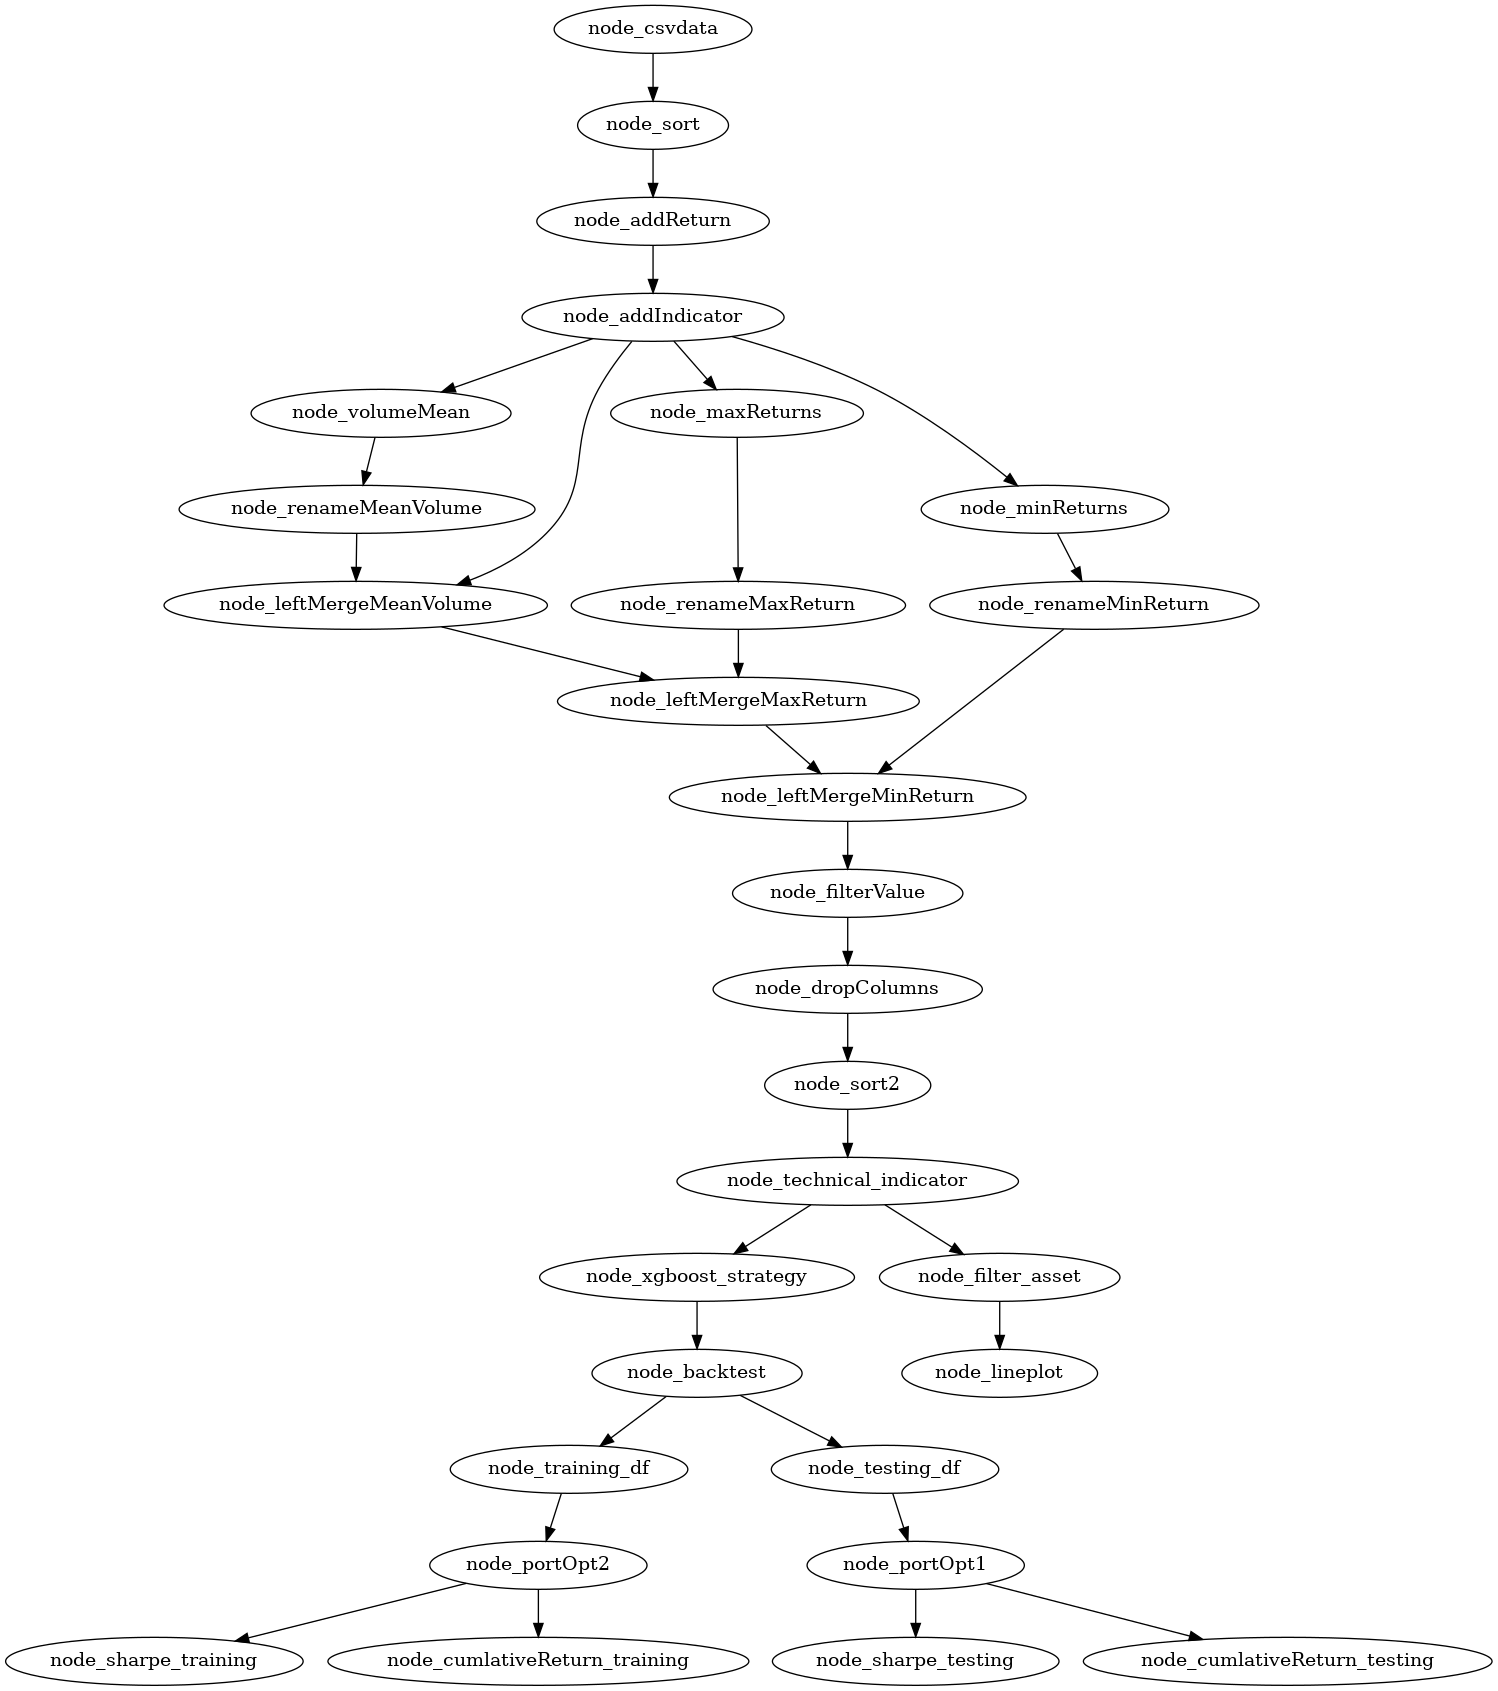

In [11]:
asset_filter = {    'id': 'node_filter_asset',
    'type': "AssetFilterNode",
    'conf': {
        "asset": 22123
    },
    "inputs": ["node_technical_indicator"]
}

node_lines ={
    "id": "node_lineplot",
    "type": "LinePlotNode",
    "conf": { "points": 300,
    "lines":
         [ {"column": "FR_DI_0.1",
            "label": "d 0.1",
            "color": "blue"},
          {"column": "FR_DI_0.3",
            "label": "d 0.3",
            "color": "orange"},
          {"column": "FR_DI_0.5",
           "label": "d 0.5",
           "color": "green"},
          {"column": "FR_DI_0.7",
           "label": "d 0.7",
           "color": "black"}
         ],
     "title": "Signals"},
   "inputs": ["node_filter_asset"]}
task_graph.extend([asset_filter, node_lines])
draw(task_graph.viz_graph(), show='ipynb')

We can run the sub-graph just for plotting the signals.

In [12]:
action = "load" if os.path.isfile('./.cache/node_csvdata.hdf5') else "save"
outlist = ['node_lineplot']
replace_spec={'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                            {"column": "returns_max", "max": max_rate},
                                            {"column": "returns_min", "min": min_rate}]},
              'node_csvdata': {action: True}}
replace_spec['node_technical_indicator'] = {"conf": indicator_conf}
#replace_spec['node_sort2'] = {"load": cached_sort}
(lineplot, ) = task_graph.run(outputs=outlist,
                              replace=replace_spec)
# display plot in jupyter
lineplot

Figure(axes=[Axis(orientation='vertical', scale=LinearScale()), Axis(label='Time', scale=DateScale())], fig_ma…

Note, smaller `d` value signal has more memory information but not as stationary as the high `d` value signals. 

### Conclusions
In this notebook, we demoed how to use Numba to implemement fractional differencing calculation in GPU. It achieves 100x speed up compared with the method done by Ensemble Capital. We also showed it is easy to use gQuant to compute fractional difference and run backtests